# Iris&digits


In [4]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm


# К задаче кросс-корреляции

In [5]:
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from sqlite3 import connect
import pandas as pd
from collections import defaultdict
import os
import numpy as np
import matplotlib.patches as plp
import scipy.stats as st
from astropy.time import Time
import scipy


class Image:
    def __init__(self, fname='', hdr={}, data=[]):
        self._fname = fname
        self.hdr = hdr
        self.data = data
    
    @property
    def width(self):
        try:
            return self.data.shape[0]
        except Exception as e:
            return 0
    
    @property
    def height(self):
        try:
            return self.data.shape[1]
        except:
            return 0
    
    @property
    def fname(self):
        return self._fname
    
    def __str__(self):
        return f"<Image {self.width}x{self.height}>"
    
    __repr__ = __str__
    
def imread(path):
    hdr, data = {}, []
    with fits.open(path, 'readonly', ignore_missing_end=True) as f:
        hdu = f[0]
        hdr = getattr(hdu, 'header', {})
        data = getattr(hdu, 'data', [])
        
    return Image(path, hdr=hdr, data=data)

def imsave(img, path=''):
    if path:
        fits.writeto(path, img.data, img.hdr, overwrite=True)
    else:
        fits.writeto(img.fname, img.data, img.hdr, overwrite=True)
        
def sql2pandas(db_path):
    
    df = defaultdict(list)
    cols = ['x', 'x_err', 'y', 'y_err', 'ra_deg', 'ra_err', 'dec_deg', 'dec_err', 'mag', 'mag_err']
    
    # Avoid creating of a new DB by sqlite3 if it doesn't exist on the path
    if not os.path.isfile(db_path):
        raise IOError(f"No such file \"{db_path}\"")
    
    # Use a context manager to automatically close the DB after reading data
    # This prevents accidental changes to the DB and release R/W block
    with connect(db_path) as conn:
        for row in conn.cursor().execute(
            'SELECT x, x_err, y, y_err, ra_deg, ra_err, dec_deg, dec_err, mag, mag_err FROM objects'):
            df['x'].append(row[0])
            df['x_err'].append(row[1])
            df['y'].append(row[2])
            df['y_err'].append(row[3])
            df['ra_deg'].append(row[4])
            df['ra_err'].append(row[5])
            df['dec_deg'].append(row[6])
            df['dec_err'].append(row[7])
            df['mag'].append(row[8])
            df['mag_err'].append(row[9])
            
    return pd.DataFrame(df, columns=cols)

In [6]:
img = imread('test.fits')

In [7]:
w = WCS(img.hdr)

xscale, yscale = (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)
field_center = SkyCoord(*w.wcs.crval, unit=[u.deg, u.deg])
region_width = img.width * xscale
region_height = img.height * yscale

# field_center: (243.9021249, 14.41539495)

ps1 = pd.read_csv("PS_20archmin.txt", sep=';')
sdss1212 = pd.read_csv("SDSS_21archmin.txt", sep=';')
# glade1=pd.read_csv("GLADE_61archmin.txt", sep=';')
#ps1=sdss16
#sdss12_pm=sdss12.dropna()
#sdss12_no_pm=sdss12.loc[~sdss12.index.isin(sdss12.dropna().index)]
#print(len(sdss12),len(sdss12_pm),len(sdss12_no_pm))

# Предобработка данных

### Каталог Pan-STARRS очищается от объектов без дат наблюдения и без данных о звездной величине в хотя бы одном из фильтров


In [8]:
suspect_list=[]

for i,j in enumerate(ps1['Epoch']): #Объекты без указания эпохи наблюдения и других данных
    try:
        float(j)+float(ps1['gmag'][i])+float(ps1['e_gmag'][i])+float(ps1['rmag'][i])+float(ps1['e_rmag'][i])+float(ps1['imag'][i])+float(ps1['e_imag'][i])+float(ps1['zmag'][i])+float(ps1['e_zmag'][i])+float(ps1['ymag'][i])+float(ps1['e_ymag'][i])
        
    except ValueError:
        suspect_list.append(i)

suspect_list.append(1)

In [9]:
ps11=ps1.drop(labels=suspect_list)

times = ps11['Epoch'].to_numpy(dtype=str)
t1 = Time(times, format='mjd', scale='utc')
t=t1.jyear

features={'RA1': ps11['RAJ2000'],
              'e_RA1': ps11['e_RAJ2000'],
                        
              'DE1': ps11['DEJ2000'],
              'e_DE1': ps11['e_DEJ2000'],
          
              'ps_id': ps11['objID'],
              
              't1': t.astype(float)-2000,
              
              'g1': ps11['gmag'],
              'e_g1': ps11['e_gmag'],
              
              'r1': ps11['rmag'],
              'e_r1': ps11['e_rmag'],
        
              'i1': ps11['imag'],
              'e_i1': ps11['e_imag'],
              
              'z1': ps11['zmag'],
              'e_z1': ps11['e_zmag'],
             
             }

ps=pd.DataFrame(data=features)
ps

,RA1,e_RA1,DE1,e_DE1,ps_id,t1,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1
3,243.906360,0.0225,14.417050,0.0161,125302439063610959,12.243727,18.2362,0.0109,17.3499,0.0043,17.0184,0.0041,16.8501,0.0037
11,243.892341,0.0294,14.407503,0.0346,125282438923739474,12.554576,21.6036,0.1197,21.4321,0.0497,21.1672,0.0483,20.9335,0.1595
12,243.901098,0.0126,14.427986,0.0146,125312439010984081,12.631426,21.8217,0.0704,20.9164,0.0318,20.4908,0.0260,20.1769,0.0460
13,243.915867,0.0186,14.416996,0.0123,125302439158680895,12.524591,21.9948,0.0772,21.0206,0.0375,19.9934,0.0185,19.5193,0.0201
16,243.915878,0.0224,14.412209,0.0185,125292439158825154,12.899494,20.8501,0.2038,20.2027,0.0602,19.8305,0.0333,19.3432,0.0330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11090,243.829784,0.0027,14.089712,0.0039,124902438298038176,11.748224,17.3763,0.0033,16.9617,0.0033,16.8131,0.0032,16.7616,0.0033
11099,244.134129,0.0162,14.661688,0.0252,125592441341354427,13.006268,20.7932,0.0792,20.3277,0.0402,19.5475,0.0372,19.1126,0.0421
11100,244.166392,0.0126,14.629055,0.0121,125552441664475399,12.757783,21.6391,0.0523,20.6876,0.0178,20.1559,0.0268,19.8775,0.0215
11101,243.933812,0.0175,14.083493,0.0170,124902439338220702,12.652307,21.0718,0.1024,20.3508,0.0417,19.6192,0.0326,19.4810,0.0629


In [10]:
suspect_list_sdss=[]

for i,j in enumerate(sdss1212['class']):
    try:
        float(j)+float(sdss1212['rmag'][i])+float(sdss1212['e_rmag'][i])
        
    except ValueError:
        suspect_list_sdss.append(i)

suspect_list_sdss

[]

In [11]:
t=sdss1212['ObsDate']-2000 

sdss12=sdss1212.drop(labels=suspect_list_sdss)

sdss_features={'RA2': sdss12['RA_ICRS'], 
              'e_RA2': sdss12['e_RA_ICRS'],
              
              'DE2': sdss12['DE_ICRS'],
              'e_DE2':sdss12['e_DE_ICRS'],
               
              'sdss_id': sdss12['objID'],
                  
              't2': t,
               
               'class': sdss12['class'],
              
              'g2': sdss12['gmag'],
              'e_g2': sdss12['e_gmag'],
              
              'r2': sdss12['rmag'],
              'e_r2': sdss12['e_rmag'],
              
              'i2': sdss12['imag'],
              'e_i2': sdss12['e_imag'],
              
              'z2': sdss12['zmag'],
              'e_z2': sdss12['e_zmag'],
               
              'pmRA2': sdss12['pmRA'],
              'e_pmRA2': sdss12['e_pmRA'],
              
              'pmDE2': sdss12['pmDE'],
              'e_pmDE2': sdss12['e_pmDE'],
              }

sdss=pd.DataFrame(data=sdss_features)
sdss

,RA2,e_RA2,DE2,e_DE2,sdss_id,t2,class,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,pmRA2,e_pmRA2,pmDE2,e_pmDE2
0,243.901639,0.070,14.418688,0.068,1237665567156536760,4.4525,6,23.867,0.387,21.864,0.094,20.442,0.043,19.591,0.071,,,,NaN
1,243.898866,0.100,14.413421,0.108,1237665567156536754,4.4525,3,23.792,0.529,21.540,0.104,21.360,0.137,23.313,0.828,,,,NaN
2,243.898211,0.102,14.413378,0.098,1237665567156536755,4.4525,6,24.281,0.413,23.198,0.228,22.421,0.178,22.812,0.487,,,,NaN
3,243.906359,0.002,14.417066,0.002,1237665567156535711,4.4525,6,18.363,0.007,17.339,0.005,16.981,0.005,16.770,0.009,-6.8,2.7,-3.5,2.7
4,243.906030,0.125,14.418227,0.108,1237665567156535712,4.4525,3,23.990,0.387,23.080,0.237,21.987,0.144,21.536,0.321,,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14116,243.952914,0.113,14.761869,0.122,1237665567693341949,4.4525,3,24.550,0.566,22.248,0.133,21.202,0.082,20.659,0.186,,,,NaN
14117,244.172364,0.090,14.647871,0.085,1237665567693471941,4.4525,6,24.089,0.372,23.159,0.230,21.758,0.107,22.075,0.449,,,,NaN
14118,244.013991,0.142,14.748216,0.116,1237665567693407614,4.4525,3,23.805,0.440,22.218,0.156,21.620,0.141,21.158,0.342,,,,NaN
14119,243.851630,0.104,14.761963,0.110,1237665567693342093,4.4525,6,24.479,0.445,22.823,0.173,22.109,0.144,21.468,0.291,,,,NaN


## Галактики SDSS

In [12]:
sdss_galaxies=sdss.loc[sdss['class']==3]
sdss_galaxies

,RA2,e_RA2,DE2,e_DE2,sdss_id,t2,class,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,pmRA2,e_pmRA2,pmDE2,e_pmDE2
1,243.898866,0.100,14.413421,0.108,1237665567156536754,4.4525,3,23.792,0.529,21.540,0.104,21.360,0.137,23.313,0.828,,,,NaN
4,243.906030,0.125,14.418227,0.108,1237665567156535712,4.4525,3,23.990,0.387,23.080,0.237,21.987,0.144,21.536,0.321,,,,NaN
7,243.909242,0.215,14.414755,0.174,1237665567156536377,4.4525,3,22.345,0.186,21.971,0.179,22.486,0.436,22.008,0.849,,,,NaN
9,243.893084,0.174,14.411468,0.103,1237665567156536333,4.4525,3,22.962,0.191,22.179,0.127,21.505,0.108,21.333,0.311,,,,NaN
11,243.903326,0.162,14.404543,0.108,1237665567156536994,4.4525,3,23.157,0.248,22.943,0.265,21.647,0.135,20.850,0.230,,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14110,244.051705,0.153,14.096958,0.210,1237668337398907846,5.3619,3,22.616,0.139,22.181,0.153,21.929,0.182,21.345,0.341,,,,NaN
14115,243.763745,0.041,14.738693,0.041,1237665567693276289,4.4525,3,22.168,0.102,20.850,0.045,20.201,0.039,19.668,0.087,,,,NaN
14116,243.952914,0.113,14.761869,0.122,1237665567693341949,4.4525,3,24.550,0.566,22.248,0.133,21.202,0.082,20.659,0.186,,,,NaN
14118,244.013991,0.142,14.748216,0.116,1237665567693407614,4.4525,3,23.805,0.440,22.218,0.156,21.620,0.141,21.158,0.342,,,,NaN


In [13]:
def separation(obj1, obj2):
    
    ra1=np.deg2rad(obj1.iloc[0])
    dec1=np.deg2rad(obj1.iloc[2])
    ra2=np.deg2rad(obj2.iloc[0])
    dec2=np.deg2rad(obj2.iloc[2])

    a = np.sin(np.abs(dec1 - dec2)/2)**2
    b = np.cos(dec1)*np.cos(dec2)*np.sin(np.abs(ra1 - ra2)/2)**2
    
    angle = 2*np.arcsin(np.sqrt(a + b))
    
    return np.degrees(angle)*3600

def separation_row(row):
    
    ra1=np.deg2rad(row['RA1'])
    dec1=np.deg2rad(row['DE1'])
    ra2=np.deg2rad(row['RA2'])
    dec2=np.deg2rad(row['DE2'])

    a = np.sin(np.abs(dec1 - dec2)/2)**2
    b = np.cos(dec1)*np.cos(dec2)*np.sin(np.abs(ra1 - ra2)/2)**2
    
    angle = 2*np.arcsin(np.sqrt(a + b))
    
    return np.degrees(angle)*3600

def candidates_circular(obj, cat, R): #для объекта obj возврат объектов каталога cat из окружности радиуса R
    
    l=cat.loc[(cat.iloc[:,0]-obj.iloc[0])**2+(cat.iloc[:,2]-obj.iloc[2])**2 < (R/3600)**2]
    
    return  l

def candidates_circular_vis(obj, cat, R, s):
    
    l=candidates_circular(obj, cat, R)
    
    fig, ax = plt.subplots(figsize=(10,10))

    ax.scatter(obj.iloc[0], obj.iloc[2], marker = 'o',
                   c = 'r',
                   s=100,
                   linewidths = 2,
                   edgecolors = 'darkred',
          alpha=0.85, label='obj.')
    
    
    ax.scatter(cat.iloc[:, 0], cat.iloc[:, 2], s=40, c='w', label='cat objects.', 
                   linewidths = 2,
                   edgecolors = 'orange',
                   alpha=0.85,)
    
    ax.scatter(l.iloc[:, 0], l.iloc[:, 2], s=15, c='orange', label='Candidates from cat')
    ax.scatter(cat.iloc[:, 0], cat.iloc[:, 2], s=5, color='g', label='sdss objects.')

    
    circle=plp.Ellipse([obj.iloc[0], obj.iloc[2]],
                      R/1800,
                      R/1800,
                      fill=0,
                      edgecolor='r')
    

    ax.add_artist(circle)
    ax.set_facecolor('black')
    ax.set_xlabel('RA, deg.')
    ax.set_ylabel('DEC, deg.')
    plt.grid()
    plt.legend()

    center=[obj.iloc[0], obj.iloc[2]]   #scaling
    delta=np.max(cat.iloc[:, 0])-np.mean(cat.iloc[:, 0])

    plt.xlim(center[0]-s*delta, center[0]+s*delta)
    plt.ylim(center[1]-s*delta, center[1]+s*delta)
    
    
def sf_pandas(row):
    
    conf_level=0.9999994267
    q=st.chi2(df=2).ppf(conf_level)
    
    a1=np.array((row['RA1'], row['DE1']),dtype=float)
    a2=np.array((row['RA2'], row['DE2']),dtype=float)
    
    d = row['angDist']/3600
    

    Vm1=np.array(([(float(row['e_RA1'])/3600)**2, 0],
                  [0, (float(row['e_DE1'])/3600)**2]))
    
    Vm2=np.array(([(float(row['e_RA2'])/3600)**2, 0],
                  [0, (float(row['e_DE2'])/3600)**2]))
    
    if a2[0]-a1[0] < 0:
        theta=np.pi+np.arctan((a2[1]-a1[1])/(a2[0]-a1[0]))
        
    else:
        theta=np.arctan((a2[1]-a1[1])/(a2[0]-a1[0]))
    
    R=np.array((
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]))
    
    R_inv=np.array((
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]))
    
    Vm1_n=R@Vm1@R_inv
    Vm2_n=R@Vm2@R_inv
    Vc=Vm1_n+Vm2_n
    
    rho_c=Vc[0][1]
    statistic=d/(np.sqrt(Vc[0][0]*(1-rho_c**2)))
    
    return statistic

# Обычная кросс-идентификация (не вблизи галактик)

In [14]:
%%time
ps_coords=SkyCoord(ps['RA1'], ps['DE1'], unit=[u.deg]*2)
# glade_coords=SkyCoord(glade['RAg'], glade['DEg'], unit=[u.deg]*2)
sdss12_coords=SkyCoord(sdss['RA2'], sdss['DE2'], unit=[u.deg]*2)
sdss12_galaxies_coords=SkyCoord(sdss_galaxies['RA2'], sdss_galaxies['DE2'], unit=[u.deg]*2)


Wall time: 638 ms


In [15]:
res1=SkyCoord.match_to_catalog_sky(ps_coords, sdss12_coords)
sep1=res1[1].to(u.arcsec).value

In [16]:
%%time

features1={'ps_id': ps.index,
             'sdss_id': sdss.loc[res1[0]].index,
             'sep_to_sdss, arcsec': sep1}

result1=pd.DataFrame(data=features1)
ps_glade_result = result1.astype({"ps_id": int,
                  "sdss_id": int,
                  'sep_to_sdss, arcsec': float})

#print('Кол-во сопоставлений: {} '.format(np.count_nonzero(result['match'])))
r1=ps_glade_result

Wall time: 2.94 ms


In [17]:
# r3=r1.join(ps, on='ps_id').join(sdss, on='sdss_id')
# r3['magdiff']=np.sqrt((r3['g1'].astype(float)-r3['g2'].astype(float))**2+(r3['r1'].astype(float)-r3['r2'].astype(float))**2+(r3['i1'].astype(float)-r3['i2'].astype(float))**2+(r3['z1'].astype(float)-r3['z2'].astype(float))**2)
# r3['r']=r3['sep_to_sdss, arcsec']/(np.sqrt(r3['e_RA1'].astype(float)**2+r3['e_RA2'].astype(float)**2+r3['e_DE1'].astype(float)**2+r3['e_DE1'].astype(float)**2))
# r3

In [18]:
def separation(obj1, obj2):
    
    ra1=np.deg2rad(obj1.iloc[0])
    dec1=np.deg2rad(obj1.iloc[2])
    ra2=np.deg2rad(obj2.iloc[0])
    dec2=np.deg2rad(obj2.iloc[2])

    a = np.sin(np.abs(dec1 - dec2)/2)**2
    b = np.cos(dec1)*np.cos(dec2)*np.sin(np.abs(ra1 - ra2)/2)**2
    
    angle = 2*np.arcsin(np.sqrt(a + b))
    
    return np.degrees(angle)

def candidates(obj, cat, R): #для объекта obj возврат объектов каталога cat из квадрата стороной 2R
    
    l=cat.loc[(cat.iloc[:,0]>obj.iloc[0]-R/3600) &
                   (cat.iloc[:,0]<obj.iloc[0]+R/3600) &
                   (cat.iloc[:,2]>obj.iloc[2]-R/3600) &
                   (cat.iloc[:,2]<obj.iloc[2]+R/3600)]
    
    return  l

def candidates_vis(obj, cat, R, s):
    
    l=candidates(obj, cat, R) #для объекта obj возврат объектов каталога cat из квадрата стороной 2R
    

    fig, ax = plt.subplots(figsize=(10,10))

    ax.scatter(obj['RA1'], obj['DE1'], marker = 'o',
                   c = 'r',
                   s=30,
                   linewidths = 2,
                   edgecolors = 'darkred',
          alpha=0.85, label='PS1 obj.')
    
    
    ax.scatter(cat.iloc[:, 0], cat.iloc[:, 2], s=5, c='w', label='SDSS DR 12 objects.')
    ax.scatter(l.iloc[:, 0], l.iloc[:, 2], s=15, c='orange', label='candidates.')
    
    square=plp.Rectangle([obj['RA1']-R/3600, obj['DE1']-R/3600],
                      R/1800,
                      R/1800,
                      fill=0,
                      edgecolor='r')
    

    ax.add_artist(square)
    ax.set_facecolor('black')
    ax.set_xlabel('RA, deg.')
    ax.set_ylabel('DEC, deg.')
    plt.grid()
    plt.legend()

    center=[obj['RA1'], obj['DE1']]   #scaling
    delta=np.max(ps['RA1'])-np.mean(ps['RA1'])

    plt.xlim(center[0]-s*delta, center[0]+s*delta)
    plt.ylim(center[1]-s*delta, center[1]+s*delta)

# Кросс-идентификация CDS

### Результаты работы CDS XMatch

In [19]:
cds=pd.read_csv("CDS XMatch.csv")
cds.iloc[:, :20]

,angDist,sigDist,objID,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,f_objID,Qual,Epoch,Ns,Nd,gmag,e_gmag,gKmag,e_gKmag,gFlags,rmag,e_rmag
0,0.261168,1.194378,125402436203383192,243.620375,14.502276,0.204,0.107,0,436527104,52,56044.880880,4,14,NaN,NaN,NaN,NaN,16416,22.0550,0.1838
1,0.431189,1.508260,125402436203383192,243.620375,14.502276,0.204,0.107,0,436527104,52,56044.880880,4,14,NaN,NaN,NaN,NaN,16416,22.0550,0.1838
2,0.232071,0.119446,125392436185995033,243.618551,14.495425,1.934,0.099,0,436527104,52,55673.836273,4,8,NaN,NaN,NaN,NaN,16416,NaN,NaN
3,0.236735,0.121847,125392436185995033,243.618551,14.495425,1.934,0.099,0,436527104,52,55673.836273,4,8,NaN,NaN,NaN,NaN,16416,NaN,NaN
4,0.286118,0.575152,125402436422047067,243.642150,14.505504,0.486,0.146,0,444915712,53,56027.160775,4,8,NaN,NaN,NaN,NaN,16416,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13136,0.169200,1.122362,125462437896474273,243.789590,14.553122,0.080,0.080,90,436363264,52,55879.464178,6,4,NaN,NaN,NaN,NaN,114720,22.1644,0.0689
13137,0.184929,1.765635,125162438413116815,243.841287,14.305268,0.041,0.040,90,436527232,52,56228.574838,4,25,NaN,NaN,NaN,NaN,16416,22.4971,0.1884
13138,0.226011,1.623091,125162438413116815,243.841287,14.305268,0.041,0.040,90,436527232,52,56228.574838,4,25,NaN,NaN,NaN,NaN,16416,22.4971,0.1884
13139,0.165011,0.552359,125462437799232185,243.779794,14.551373,0.159,0.121,0,444915712,53,56107.801644,5,12,NaN,NaN,NaN,NaN,114720,21.9617,0.0838


## Объекты Pan-STARRS

In [20]:
ps_frame=cds.iloc[:,:38][['angDist','RAJ2000', 'errHalfMaj','DEJ2000', 'errHalfMin', 'errPosAng', 'objID', 'gmag','e_gmag','rmag','e_rmag','imag','e_imag','zmag','e_zmag']]
sdss_frame=cds.iloc[:,38:][['RAdeg', 'errHalfMaj.1', 'DEdeg', 'errHalfMin.1', 'errPosAng.1', 'objID.1', 'gmag.1','e_gmag.1','rmag.1','e_rmag.1','imag.1','e_imag.1','zmag.1','e_zmag.1']]

In [21]:
sdss_frame.rename(columns={"RAdeg":"RA2",
                        
                      'DEdeg':'DE2',
                        
                      'objID.1':'sdss_id',
                      'gmag.1':'g2',
                      'e_gmag.1':'e_g2',
                      'rmag.1':'r2',
                      'e_rmag.1':'e_r2',
                      'imag.1':'i2',
                      'e_imag.1':'e_i2',
                      'zmag.1':'z2',
                      'e_zmag.1':'e_z2'}, inplace=True)

In [22]:
ps_frame['index']=ps_frame.index

## Объекты Pan-STARRS без дубликатов и со всеми фильтрами

In [23]:
df_price=ps_frame.loc[~ps_frame['objID'].duplicated(keep=False)].dropna()

a1=sdss_frame.loc[df_price.index]
index_to_drop=a1.loc[a1['sdss_id'].duplicated(keep=False)].index

ps_11=df_price.loc[~df_price.index.isin(index_to_drop)]
ps_11

,angDist,RAJ2000,errHalfMaj,DEJ2000,errHalfMin,errPosAng,objID,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,index
20,0.078340,243.630099,0.031,14.502682,0.023,0,125402436301113756,22.3130,0.1207,21.4454,0.0454,20.7675,0.0562,20.5020,0.0861,20
29,0.036719,243.629207,0.009,14.502601,0.003,0,125402436292263653,21.6874,0.0352,20.5605,0.0141,19.4077,0.0108,18.9439,0.0250,29
59,0.132467,243.656413,0.037,14.530144,0.019,0,125432436564206707,20.9795,0.0645,20.4825,0.0274,20.2425,0.0139,20.1511,0.0305,59
65,0.021067,243.648006,0.004,14.509205,0.004,90,125412436481101435,19.8944,0.0072,18.8993,0.0055,18.3500,0.0045,18.0613,0.0123,65
105,0.049895,243.629373,0.008,14.514814,0.007,0,125412436293788302,21.6351,0.0243,20.5576,0.0159,19.5250,0.0092,19.0308,0.0188,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13112,0.068195,243.851722,0.020,14.305625,0.015,0,125162438517407220,22.3774,0.1647,21.5481,0.0557,20.7911,0.0311,20.3146,0.0508,13112
13113,0.098726,243.858618,0.013,14.297826,0.010,0,125152438586227855,22.2067,0.2199,21.1226,0.0437,20.2516,0.0258,19.8075,0.0143,13113
13124,0.218903,243.863511,0.069,14.298826,0.032,0,125152438635458983,21.9547,0.0822,21.6810,0.0812,21.3412,0.0728,21.2870,0.3427,13124
13133,0.045299,243.857524,0.017,14.314648,0.009,0,125172438575518039,17.5234,0.0029,16.6916,0.0042,16.3562,0.0017,16.2038,0.0033,13133


In [24]:
ps_11.rename(columns={"RAJ2000":"RA1",      
                      'DEJ2000':'DE1',
                      'objID':'ps_id',
                      'gmag':'g1',
                      'e_gmag':'e_g1',
                      'rmag':'r1',
                      'e_rmag':'e_r1',
                      'imag':'i1',
                      'e_imag':'e_i1',
                      'zmag':'z1',
                      'e_zmag':'e_z1'}, inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
era1=ps_11['errHalfMaj']*np.cos(np.deg2rad(ps_11['errPosAng']))+ps_11['errHalfMin']*np.sin(np.deg2rad(ps_11['errPosAng']))
ede1=ps_11['errHalfMaj']*np.sin(np.deg2rad(ps_11['errPosAng']))+ps_11['errHalfMin']*np.cos(np.deg2rad(ps_11['errPosAng']))
ps_1=ps_11.drop(['errHalfMaj', 'errHalfMin', 'errPosAng', 'index'], axis=1)
ps_1

,angDist,RA1,DE1,ps_id,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1
20,0.078340,243.630099,14.502682,125402436301113756,22.3130,0.1207,21.4454,0.0454,20.7675,0.0562,20.5020,0.0861
29,0.036719,243.629207,14.502601,125402436292263653,21.6874,0.0352,20.5605,0.0141,19.4077,0.0108,18.9439,0.0250
59,0.132467,243.656413,14.530144,125432436564206707,20.9795,0.0645,20.4825,0.0274,20.2425,0.0139,20.1511,0.0305
65,0.021067,243.648006,14.509205,125412436481101435,19.8944,0.0072,18.8993,0.0055,18.3500,0.0045,18.0613,0.0123
105,0.049895,243.629373,14.514814,125412436293788302,21.6351,0.0243,20.5576,0.0159,19.5250,0.0092,19.0308,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...
13112,0.068195,243.851722,14.305625,125162438517407220,22.3774,0.1647,21.5481,0.0557,20.7911,0.0311,20.3146,0.0508
13113,0.098726,243.858618,14.297826,125152438586227855,22.2067,0.2199,21.1226,0.0437,20.2516,0.0258,19.8075,0.0143
13124,0.218903,243.863511,14.298826,125152438635458983,21.9547,0.0822,21.6810,0.0812,21.3412,0.0728,21.2870,0.3427
13133,0.045299,243.857524,14.314648,125172438575518039,17.5234,0.0029,16.6916,0.0042,16.3562,0.0017,16.2038,0.0033


In [26]:
# df_price=ps_frame.groupby(['objID']).min(['angDist']).dropna()
# ps_11=ps_frame.loc[ps_frame.index.isin(df_price['index'])].sort_index(axis=0)
# ps_11

In [27]:
# ps_11.rename(columns={"RAJ2000":"RA1",      
#                       'DEJ2000':'DE1',
#                       'objID':'ps_id',
#                       'gmag':'g1',
#                       'e_gmag':'e_g1',
#                       'rmag':'r1',
#                       'e_rmag':'e_r1',
#                       'imag':'i1',
#                       'e_imag':'e_i1',
#                       'zmag':'z1',
#                       'e_zmag':'e_z1'}, inplace=True)

In [28]:
# era1=ps_11['errHalfMaj']*np.cos(np.deg2rad(ps_11['errPosAng']))+ps_11['errHalfMin']*np.sin(np.deg2rad(ps_11['errPosAng']))
# ede1=ps_11['errHalfMaj']*np.sin(np.deg2rad(ps_11['errPosAng']))+ps_11['errHalfMin']*np.cos(np.deg2rad(ps_11['errPosAng']))
# ps_1=ps_11.drop(['errHalfMaj', 'errHalfMin', 'errPosAng', 'index'], axis=1)

In [29]:
ps_1['e_RA1']=era1
ps_1['e_DE1']=ede1

ps_matched=ps_1[['RA1', 'e_RA1', 'DE1', 'e_DE1', 'ps_id', 'g1', 'e_g1', 'r1', 'e_r1', 'i1', 'e_i1', 'z1', 'e_z1']]
ps_matched

,RA1,e_RA1,DE1,e_DE1,ps_id,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1
20,243.630099,0.031,14.502682,0.023,125402436301113756,22.3130,0.1207,21.4454,0.0454,20.7675,0.0562,20.5020,0.0861
29,243.629207,0.009,14.502601,0.003,125402436292263653,21.6874,0.0352,20.5605,0.0141,19.4077,0.0108,18.9439,0.0250
59,243.656413,0.037,14.530144,0.019,125432436564206707,20.9795,0.0645,20.4825,0.0274,20.2425,0.0139,20.1511,0.0305
65,243.648006,0.004,14.509205,0.004,125412436481101435,19.8944,0.0072,18.8993,0.0055,18.3500,0.0045,18.0613,0.0123
105,243.629373,0.008,14.514814,0.007,125412436293788302,21.6351,0.0243,20.5576,0.0159,19.5250,0.0092,19.0308,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13112,243.851722,0.020,14.305625,0.015,125162438517407220,22.3774,0.1647,21.5481,0.0557,20.7911,0.0311,20.3146,0.0508
13113,243.858618,0.013,14.297826,0.010,125152438586227855,22.2067,0.2199,21.1226,0.0437,20.2516,0.0258,19.8075,0.0143
13124,243.863511,0.069,14.298826,0.032,125152438635458983,21.9547,0.0822,21.6810,0.0812,21.3412,0.0728,21.2870,0.3427
13133,243.857524,0.017,14.314648,0.009,125172438575518039,17.5234,0.0029,16.6916,0.0042,16.3562,0.0017,16.2038,0.0033


## Объекты SDSS 

In [30]:
sdss_matched1=sdss_frame.loc[ps_matched.index]
sdss_matched1

,RA2,errHalfMaj.1,DE2,errHalfMin.1,errPosAng.1,sdss_id,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2
20,243.630087,0.035,14.502700,0.033,0,1237665531187954775,22.718,0.124,21.387,0.057,20.819,0.056,20.432,0.157
29,243.629217,0.017,14.502603,0.016,0,1237665531187954774,21.999,0.068,20.528,0.029,19.435,0.019,18.790,0.039
59,243.656411,0.018,14.530180,0.016,0,1237665531187954826,21.092,0.035,20.468,0.028,20.222,0.035,20.258,0.142
65,243.648010,0.005,14.509210,0.005,0,1237665531187954107,20.058,0.017,18.868,0.010,18.341,0.010,17.923,0.020
105,243.629368,0.017,14.514827,0.017,0,1237665531187954762,21.976,0.067,20.592,0.030,19.510,0.020,19.016,0.047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13112,243.851722,0.060,14.305644,0.059,0,1237665548365463938,23.487,0.332,21.606,0.088,20.895,0.065,20.719,0.210
13113,243.858596,0.044,14.297843,0.042,90,1237665548365464528,22.563,0.150,21.165,0.060,20.227,0.037,19.772,0.092
13124,243.863524,0.115,14.298766,0.095,0,1237665548365464535,21.719,0.080,21.573,0.096,21.373,0.113,20.897,0.282
13133,243.857524,0.002,14.314635,0.002,90,1237665548365463925,17.630,0.005,16.685,0.004,16.339,0.004,16.147,0.007


In [31]:
# ps_matched0=ps_1.loc[~ps_1.index.isin(index_todrop)]

In [32]:
# ps_matched=ps_matched0[['RA1', 'e_RA1', 'DE1', 'e_DE1', 'ps_id', 'g1', 'e_g1', 'r1', 'e_r1', 'i1', 'e_i1', 'z1', 'e_z1']]

In [33]:
# sdss_matched1=sdss_11.loc[ps_matched.index]

In [34]:
era2=sdss_matched1['errHalfMaj.1']*np.cos(np.deg2rad(sdss_matched1['errPosAng.1']))+sdss_matched1['errHalfMin.1']*np.sin(np.deg2rad(sdss_matched1['errPosAng.1']))
ede2=sdss_matched1['errHalfMaj.1']*np.sin(np.deg2rad(sdss_matched1['errPosAng.1']))+sdss_matched1['errHalfMin.1']*np.cos(np.deg2rad(sdss_matched1['errPosAng.1']))

In [35]:
sdss_matched1['e_RA2']=era2
sdss_matched1['e_DE2']=ede2

In [36]:
sdss_matched0=sdss_matched1.drop(['errHalfMaj.1', 'errHalfMin.1', 'errPosAng.1'], axis=1)
sdss_matched=sdss_matched0[['RA2', 'e_RA2', 'DE2', 'e_DE2', 'sdss_id', 'g2', 'e_g2', 'r2', 'e_r2', 'i2', 'e_i2', 'z2', 'e_z2']]
sdss_matched

,RA2,e_RA2,DE2,e_DE2,sdss_id,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2
20,243.630087,0.035,14.502700,0.033,1237665531187954775,22.718,0.124,21.387,0.057,20.819,0.056,20.432,0.157
29,243.629217,0.017,14.502603,0.016,1237665531187954774,21.999,0.068,20.528,0.029,19.435,0.019,18.790,0.039
59,243.656411,0.018,14.530180,0.016,1237665531187954826,21.092,0.035,20.468,0.028,20.222,0.035,20.258,0.142
65,243.648010,0.005,14.509210,0.005,1237665531187954107,20.058,0.017,18.868,0.010,18.341,0.010,17.923,0.020
105,243.629368,0.017,14.514827,0.017,1237665531187954762,21.976,0.067,20.592,0.030,19.510,0.020,19.016,0.047
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13112,243.851722,0.060,14.305644,0.059,1237665548365463938,23.487,0.332,21.606,0.088,20.895,0.065,20.719,0.210
13113,243.858596,0.042,14.297843,0.044,1237665548365464528,22.563,0.150,21.165,0.060,20.227,0.037,19.772,0.092
13124,243.863524,0.115,14.298766,0.095,1237665548365464535,21.719,0.080,21.573,0.096,21.373,0.113,20.897,0.282
13133,243.857524,0.002,14.314635,0.002,1237665548365463925,17.630,0.005,16.685,0.004,16.339,0.004,16.147,0.007


## Выборка идентифицированных объектов (класс "1")

In [37]:
rtot=ps_matched.join(sdss_matched).join(cds['angDist'])
rtot

,RA1,e_RA1,DE1,e_DE1,ps_id,g1,e_g1,r1,e_r1,i1,...,sdss_id,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,angDist
20,243.630099,0.031,14.502682,0.023,125402436301113756,22.3130,0.1207,21.4454,0.0454,20.7675,...,1237665531187954775,22.718,0.124,21.387,0.057,20.819,0.056,20.432,0.157,0.078340
29,243.629207,0.009,14.502601,0.003,125402436292263653,21.6874,0.0352,20.5605,0.0141,19.4077,...,1237665531187954774,21.999,0.068,20.528,0.029,19.435,0.019,18.790,0.039,0.036719
59,243.656413,0.037,14.530144,0.019,125432436564206707,20.9795,0.0645,20.4825,0.0274,20.2425,...,1237665531187954826,21.092,0.035,20.468,0.028,20.222,0.035,20.258,0.142,0.132467
65,243.648006,0.004,14.509205,0.004,125412436481101435,19.8944,0.0072,18.8993,0.0055,18.3500,...,1237665531187954107,20.058,0.017,18.868,0.010,18.341,0.010,17.923,0.020,0.021067
105,243.629373,0.008,14.514814,0.007,125412436293788302,21.6351,0.0243,20.5576,0.0159,19.5250,...,1237665531187954762,21.976,0.067,20.592,0.030,19.510,0.020,19.016,0.047,0.049895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13112,243.851722,0.020,14.305625,0.015,125162438517407220,22.3774,0.1647,21.5481,0.0557,20.7911,...,1237665548365463938,23.487,0.332,21.606,0.088,20.895,0.065,20.719,0.210,0.068195
13113,243.858618,0.013,14.297826,0.010,125152438586227855,22.2067,0.2199,21.1226,0.0437,20.2516,...,1237665548365464528,22.563,0.150,21.165,0.060,20.227,0.037,19.772,0.092,0.098726
13124,243.863511,0.069,14.298826,0.032,125152438635458983,21.9547,0.0822,21.6810,0.0812,21.3412,...,1237665548365464535,21.719,0.080,21.573,0.096,21.373,0.113,20.897,0.282,0.218903
13133,243.857524,0.017,14.314648,0.009,125172438575518039,17.5234,0.0029,16.6916,0.0042,16.3562,...,1237665548365463925,17.630,0.005,16.685,0.004,16.339,0.004,16.147,0.007,0.045299


## Выборка не идентифицированных объектов (класс "-1")

In [38]:
sdss_not_matched1=sdss_frame.loc[~sdss_frame['sdss_id'].isin(sdss_matched['sdss_id'])]

era22=sdss_not_matched1['errHalfMaj.1']*np.cos(np.deg2rad(sdss_not_matched1['errPosAng.1']))+sdss_not_matched1['errHalfMin.1']*np.sin(np.deg2rad(sdss_not_matched1['errPosAng.1']))
ede22=sdss_not_matched1['errHalfMaj.1']*np.sin(np.deg2rad(sdss_not_matched1['errPosAng.1']))+sdss_not_matched1['errHalfMin.1']*np.cos(np.deg2rad(sdss_not_matched1['errPosAng.1']))

sdss_not_matched1['e_RA2']=era22
sdss_not_matched1['e_DE2']=ede22

sdss_not_matched=sdss_not_matched1.drop(['errHalfMaj.1', 'errHalfMin.1', 'errPosAng.1'], axis=1)
sdss_not_matched

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,RA2,DE2,sdss_id,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,e_RA2,e_DE2
0,243.620416,14.502215,1237665567156405242,23.174,0.199,22.307,0.121,21.327,0.081,20.807,0.173,0.078,0.076
1,243.620348,14.502159,1237665531187955139,23.382,0.309,22.016,0.142,20.851,0.086,20.622,0.281,0.200,0.152
2,243.618496,14.495390,1237665567156405731,23.384,0.316,22.210,0.154,21.495,0.130,21.058,0.293,0.190,0.149
3,243.618520,14.495484,1237665531187955141,25.876,0.543,22.407,0.179,21.773,0.171,20.938,0.327,0.190,0.125
4,243.642213,14.505452,1237665567156405763,23.075,0.268,21.977,0.139,21.239,0.115,20.620,0.222,0.108,0.140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13136,243.789639,14.553126,1237668337935582153,23.046,0.164,22.359,0.165,22.019,0.181,21.795,0.450,0.099,0.128
13137,243.841281,14.305217,1237665567156536729,24.067,0.601,21.775,0.114,20.907,0.083,20.419,0.187,0.097,0.092
13138,243.841232,14.305300,1237665548365464892,24.631,0.766,22.539,0.219,21.412,0.115,20.743,0.239,0.100,0.133
13139,243.779756,14.551401,1237668337935581585,22.938,0.264,21.237,0.106,20.671,0.097,20.936,0.395,0.147,0.273


In [39]:
# sdss_not_matched=sdss_1.loc[~sdss_111['sdss_id'].isin(rtot['sdss_id'].values)]

## Смотр

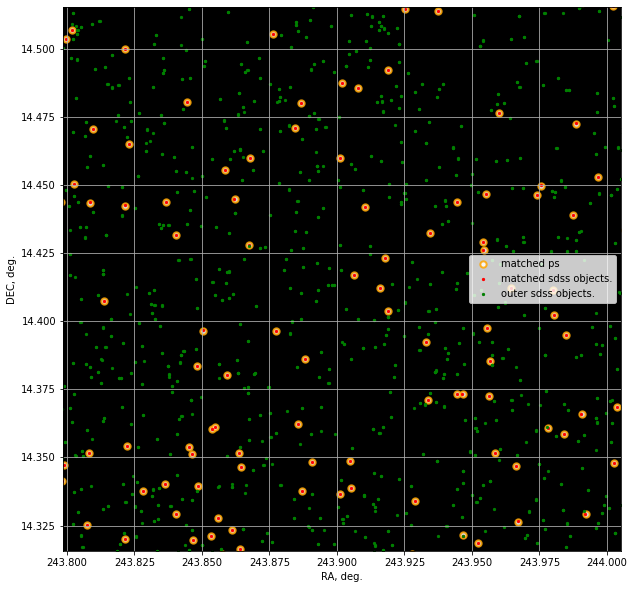

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

# ax.scatter(ps_1['RA1'], ps_1['DEJ2000'], s=5, c='w', label='all ps obj.')

ax.scatter(rtot['RA1'], rtot['DE1'], s=40, c='w', label='matched ps', 
                   linewidths = 2,
                   edgecolors = 'orange',
                   alpha=0.85,)

# ax.scatter(sdss['RA2'], sdss['DE2'], s=5, color='g', label='all sdss objects.')

ax.scatter(rtot['RA2'], rtot['DE2'], s=5, color='r', label='matched sdss objects.')

ax.scatter(sdss_not_matched['RA2'], sdss_not_matched['DE2'], s=5, color='g', label='outer sdss objects.')

ax.set_facecolor('black')
ax.set_xlabel('RA, deg.')
ax.set_ylabel('DEC, deg.')
plt.grid()
plt.legend()

marg=0.35
ax.margins(-marg, -marg)

In [41]:
# candidates_vis(ps_matched.iloc[0], sdss_frame, 5, 0.01)

## Ближайшие объекты Pan-STARRS для not_matched_sdss

In [42]:
%%time
ps_coords=SkyCoord(ps_matched['RA1'], ps_matched['DE1'], unit=[u.deg]*2)
sdss_nm_coords=SkyCoord(sdss_not_matched['RA2'], sdss_not_matched['DE2'], unit=[u.deg]*2)

res2=SkyCoord.match_to_catalog_sky(sdss_nm_coords, ps_coords)
sep2=res2[1].to(u.arcsec).value

Wall time: 389 ms


In [43]:
%%time

features2={'sdss_nm_id': sdss_not_matched.index,
           'ps_ID': ps_matched.iloc[res2[0]].index,
           'sep_to_ps, arcsec': sep2}

result2=pd.DataFrame(data=features2)
ps_glade_result = result2.astype({"sdss_nm_id": int,
                  "ps_ID": int,
                  'sep_to_ps, arcsec': float})


#print('Кол-во сопоставлений: {} '.format(np.count_nonzero(result['match'])))
r2=ps_glade_result
r2

Wall time: 2.98 ms


,sdss_nm_id,ps_ID,"sep_to_ps, arcsec"
0,0,29,30.670006
1,1,29,30.916483
2,2,29,45.469176
3,3,29,45.207883
4,4,65,24.293976
...,...,...,...
12258,13136,7153,16.574941
12259,13137,7273,33.748848
12260,13138,7273,33.565673
12261,13139,7153,19.288206


In [44]:
rtot

,RA1,e_RA1,DE1,e_DE1,ps_id,g1,e_g1,r1,e_r1,i1,...,sdss_id,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2,angDist
20,243.630099,0.031,14.502682,0.023,125402436301113756,22.3130,0.1207,21.4454,0.0454,20.7675,...,1237665531187954775,22.718,0.124,21.387,0.057,20.819,0.056,20.432,0.157,0.078340
29,243.629207,0.009,14.502601,0.003,125402436292263653,21.6874,0.0352,20.5605,0.0141,19.4077,...,1237665531187954774,21.999,0.068,20.528,0.029,19.435,0.019,18.790,0.039,0.036719
59,243.656413,0.037,14.530144,0.019,125432436564206707,20.9795,0.0645,20.4825,0.0274,20.2425,...,1237665531187954826,21.092,0.035,20.468,0.028,20.222,0.035,20.258,0.142,0.132467
65,243.648006,0.004,14.509205,0.004,125412436481101435,19.8944,0.0072,18.8993,0.0055,18.3500,...,1237665531187954107,20.058,0.017,18.868,0.010,18.341,0.010,17.923,0.020,0.021067
105,243.629373,0.008,14.514814,0.007,125412436293788302,21.6351,0.0243,20.5576,0.0159,19.5250,...,1237665531187954762,21.976,0.067,20.592,0.030,19.510,0.020,19.016,0.047,0.049895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13112,243.851722,0.020,14.305625,0.015,125162438517407220,22.3774,0.1647,21.5481,0.0557,20.7911,...,1237665548365463938,23.487,0.332,21.606,0.088,20.895,0.065,20.719,0.210,0.068195
13113,243.858618,0.013,14.297826,0.010,125152438586227855,22.2067,0.2199,21.1226,0.0437,20.2516,...,1237665548365464528,22.563,0.150,21.165,0.060,20.227,0.037,19.772,0.092,0.098726
13124,243.863511,0.069,14.298826,0.032,125152438635458983,21.9547,0.0822,21.6810,0.0812,21.3412,...,1237665548365464535,21.719,0.080,21.573,0.096,21.373,0.113,20.897,0.282,0.218903
13133,243.857524,0.017,14.314648,0.009,125172438575518039,17.5234,0.0029,16.6916,0.0042,16.3562,...,1237665548365463925,17.630,0.005,16.685,0.004,16.339,0.004,16.147,0.007,0.045299


(-1.0, 150.0)

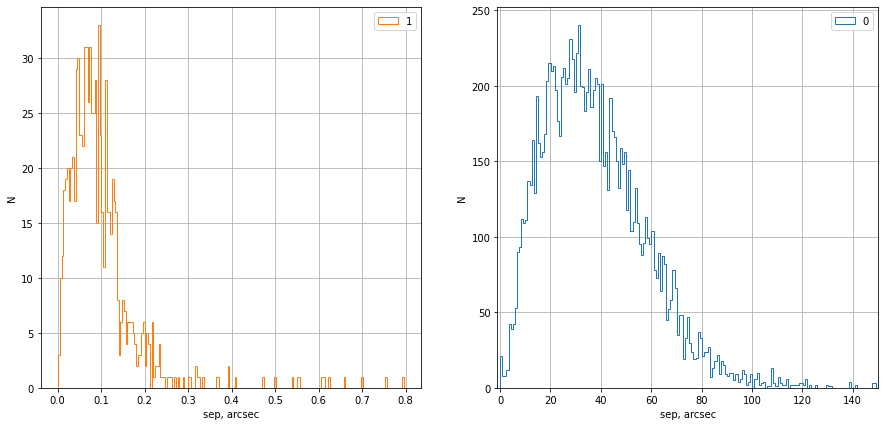

In [45]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,7))

a1,a2,a3=ax1.hist(rtot['angDist'],bins=200, histtype='step', label='1', color='C1')
a1,a2,a3=ax2.hist(r2['sep_to_ps, arcsec'],bins=200, histtype='step', label='0')

ax1.grid()
ax2.grid()

ax1.set_xlabel('sep, arcsec')
ax1.set_ylabel('N')

ax2.set_xlabel('sep, arcsec')
ax2.set_ylabel('N')

ax1.legend()
ax2.legend()

plt.xlim(-1,150)

In [46]:
rtot_nm1=r2[r2['sep_to_ps, arcsec']>0]
rtot_nm=rtot_nm1.join(ps_matched, on='ps_ID').join(sdss_not_matched, on='sdss_nm_id').drop(['sdss_nm_id','ps_ID'], axis=1)

In [47]:
rtot_nm['target']=0
rtot_nm.rename(columns={"sep_to_ps, arcsec":"angDist"}, inplace=True)
# rtot_nm=rtot_nm.drop(['ps_id'], axis=1)

In [48]:
# rtot_nm.iloc[np.argsort(rtot_nm['angDist'])][:1000]

In [49]:
rtot['target']=1

In [50]:
resulting_data=pd.concat([rtot, rtot_nm.iloc[np.argsort(rtot_nm['angDist'])][:850]]) #1000 ближайших
# resulting_data=pd.concat([rtot, rtot_nm.iloc[np.random.randint(0,len(rtot_nm),2000)]]) #1000 случайных

In [51]:
# resulting_data['sigDist']=resulting_data.apply(sf_pandas, axis=1)

In [52]:
d = {#'sigDist': resulting_data['sigDist'],
    
     'dg': (resulting_data['g1']-resulting_data['g2']),
     'dr': (resulting_data['r1']-resulting_data['r2']),
     'di': (resulting_data['i1']-resulting_data['i2']),
     'dz': (resulting_data['z1']-resulting_data['z2']),
    
     'e_g1': (resulting_data['e_g1']),
     'e_r1': (resulting_data['e_r1']),
     'e_i1': (resulting_data['e_i1']),
     'e_z1': (resulting_data['e_z1']),
    
     'e_g2': (resulting_data['e_g2']),
     'e_r2': (resulting_data['e_r2']),
     'e_i2': (resulting_data['e_i2']),
     'e_z2': (resulting_data['e_z2']),
     
     'e_RA1': resulting_data['e_RA1'],
     'e_DE1': resulting_data['e_DE1'],
     'e_RA2': resulting_data['e_RA2'],
     'e_DE2': resulting_data['e_DE2'],
     }
df = pd.DataFrame(data=d)

# Выбор фичей и обучение

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import svm
import umap.umap_ as umap
from sklearn.metrics import confusion_matrix,plot_roc_curve, roc_curve,roc_auc_score,accuracy_score,precision_score,recall_score, plot_confusion_matrix,plot_precision_recall_curve, balanced_accuracy_score, precision_recall_curve, fbeta_score, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

reducer = umap.UMAP()

In [54]:
X_i=np.array((resulting_data['g1']-resulting_data['g2'],
              resulting_data['r1']-resulting_data['r2'],
              resulting_data['i1']-resulting_data['i2'],
              resulting_data['z1']-resulting_data['z2'])).T

Y_i=np.array((resulting_data['target']))
Y=np.reshape(Y_i, (len(Y_i), 1))

In [55]:
# cor_matrix = df.corr().abs()
# upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
# to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
# df1 = df.drop(to_drop, axis=1)
# print(to_drop)
# df1

In [56]:
# X_i1=np.array((df[['dg', 'dr', 'di', 'dz']]))
# # X_i1=np.array((df[['dg', 'dr', 'di', 'dz', 'e_g1',  'e_g2', 'e_r1',  'e_r2', 'e_i1',  'e_i2', 'e_RA1', 'e_DE1', 'e_RA2', 'e_DE2']]))
# # X_i1=np.array((df1))

# Y_i=np.array((resulting_data['target']))
# Y=np.reshape(Y_i, (len(Y_i), 1))

In [57]:
# plt.subplots(figsize=(12,5))

# correlation=df1.corr()
# sns.heatmap(correlation,annot=True,cmap='RdPu')
# plt.title('Correlation between the variables')
# plt.xticks(rotation=45)

In [58]:
# sc = StandardScaler()
# sc.fit(X_i1)
# X_i_scaled=sc.transform(X_i1)

In [59]:
embedding = reducer.fit_transform(X_i)

In [60]:
df_1 = pd.DataFrame(np.concatenate((embedding,Y),axis=1), columns=['component1', 'component2', 'target'])

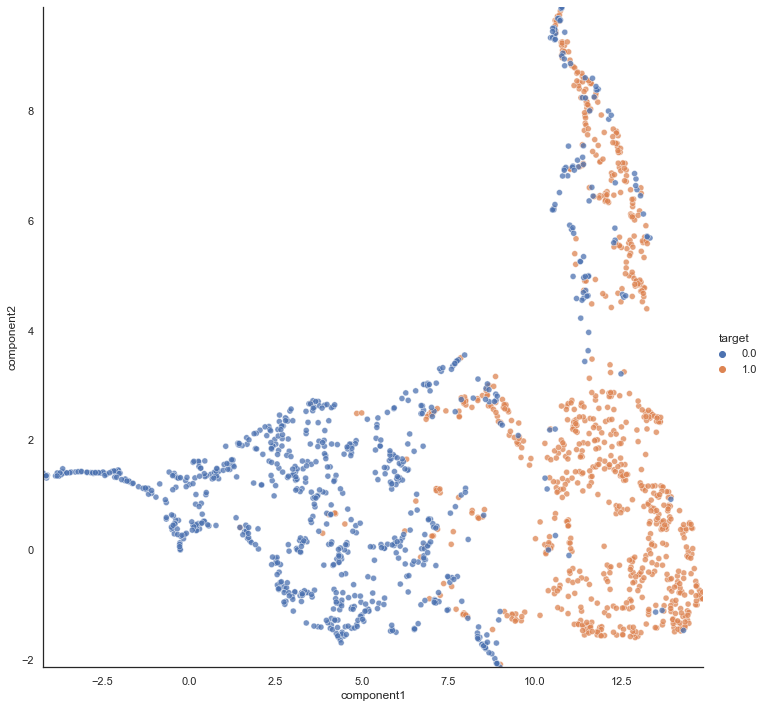

In [61]:
sns.set(rc = {'figure.figsize':(25,18)})
sns.set_theme(style="white")
sns.relplot(x="component1", y="component2", alpha=.75, hue="target", data=df_1,height=10)
# plt.ylim(-7, 7)
# plt.xlim(-5, 5)

marg=0
plt.margins(-marg, -marg)

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X_i, Y, test_size=.33, random_state=42)

In [63]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=1/10)
ftwo_scorer

make_scorer(fbeta_score, beta=0.1)

In [64]:
def get_beta(table, beta):
    return ((1+beta**2)*table['precision']*table['recall'])/(beta**2*table['precision']+table['recall'])

## SVM

In [88]:
from sklearn.model_selection import GridSearchCV

ml_svm = svm.SVC(kernel='poly', probability=True) 
knn = KNeighborsClassifier()
logreg=LogisticRegression()

scor=['precision', 'recall'] 

search_space_poly = {'C': [0.1, 1, 10],
              'kernel': ['poly'],
              'gamma': [0.1, 1, 10],
              'degree': [3]} 

search_space_rbf = {'C': [0.1, 1, 10], 
              'gamma': [100, 10, 1],
              'kernel': ['rbf']} 

search_space_knn = {'n_neighbors': list(range(1, 6)),
                 'weights': ['uniform', 'distance'],
                 'metric': ['minkowski','euclidean', 'manhattan']}

search_space_logreg={'C': [0.0001, 0.001, 0.01, 0.1, 1],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty': ['l1', 'l2', 'elasticnet'],}
  
grid = GridSearchCV(ml_svm, search_space_rbf, refit=True, verbose = 3,cv=5, scoring='accuracy')
grid_search=grid.fit(X_i, Y_i)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.712 total time=   0.4s
[CV 2/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.732 total time=   0.5s
[CV 3/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.723 total time=   0.4s
[CV 4/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.667 total time=   0.4s
[CV 5/5] END ......C=0.1, gamma=100, kernel=rbf;, score=0.681 total time=   0.5s
[CV 1/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.871 total time=   0.2s
[CV 2/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.920 total time=   0.2s
[CV 3/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.888 total time=   0.2s
[CV 4/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.876 total time=   0.2s
[CV 5/5] END .......C=0.1, gamma=10, kernel=rbf;, score=0.885 total time=   0.2s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.856 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;,

In [79]:
# res=pd.concat([pd.DataFrame(grid.cv_results_["params"]),
#            pd.DataFrame(grid.cv_results_["mean_test_precision"], columns=["precision"])*100,
#            pd.DataFrame(grid.cv_results_["std_test_precision"], columns=["std_precision"])*100,
#            pd.DataFrame(grid.cv_results_["mean_test_recall"], columns=["recall"])*100,
#            pd.DataFrame(grid.cv_results_["std_test_recall"], columns=["std_recall"])*100,],axis=1)

# res['f_beta']=get_beta(res, 1/2)
# res.nlargest(15, 'f_beta')

In [89]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [90]:
# y_test_hat=grid.predict(X_test)

# test_accuracy=accuracy_score(Y_test,y_test_hat)*100
# test_precision=precision_score(Y_test,y_test_hat)*100
# test_recall=recall_score(Y_test,y_test_hat)*100

# print("Achived accuracy : {:.2f}%".format(test_accuracy))
# print("Achived precision : {:.2f}%".format(test_precision))
# print("Achived recall : {:.2f}%".format(test_recall))

In [91]:
results=[]
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X_i, Y, test_size=.25, random_state=i+1)
    y_test_hat1=grid.predict(x_test)
    
    results.append((accuracy_score(y_test, y_test_hat1)*100, precision_score(y_test, y_test_hat1)*100, recall_score(y_test, y_test_hat1)*100))

In [92]:
print("Achived accuracy : {:.2f}%".format(np.mean(np.array((results))[:,0])))
print("Achived precision : {:.2f}%".format(np.mean(np.array((results))[:,1])))
print("Achived recall : {:.2f}%".format(np.mean(np.array((results))[:,2])))

Achived accuracy : 95.47%
Achived precision : 93.47%
Achived recall : 97.66%


In [93]:
import pickle

In [96]:
filename = 'finalized_model3.sav'
pickle.dump(grid, open(filename, 'wb'))

In [97]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_i[100:1100])
print(result)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 

## KNN

In [180]:
knn = KNeighborsClassifier()

scor=['precision', 'recall', 'accuracy']

search_space2 = {'n_neighbors': list(range(1, 3)),
                 'weights': ['uniform', 'distance'],
                 'metric': ['minkowski','euclidean', 'manhattan']}

grid2 = GridSearchCV(knn, search_space2, cv=5,verbose=3, scoring=scor, refit='precision')
grid_search2=grid2.fit(X_i, Y_i)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END metric=minkowski, n_neighbors=1, weights=uniform; accuracy: (test=0.882) precision: (test=0.832) recall: (test=0.959) total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=1, weights=uniform; accuracy: (test=0.950) precision: (test=0.963) recall: (test=0.935) total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=1, weights=uniform; accuracy: (test=0.932) precision: (test=0.940) recall: (test=0.923) total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=1, weights=uniform; accuracy: (test=0.909) precision: (test=0.879) recall: (test=0.947) total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=1, weights=uniform; accuracy: (test=0.935) precision: (test=0.930) recall: (test=0.941) total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=1, weights=distance; accuracy: (test=0.882) precision: (test=0.832) recall: (test=0.959) total time=   0.0s
[CV 2/5] END metric=minkowski, n_neigh

In [127]:
print(grid_search2.best_params_)

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}


In [128]:
y_test_hat2=grid2.predict(X_test)
test_accuracy2=accuracy_score(Y_test,y_test_hat2)*100
test_precision2=precision_score(Y_test,y_test_hat2)*100
test_recall2=recall_score(Y_test,y_test_hat2)*100


print("Achived accuracy : {:.2f}%".format(test_accuracy2))
print("Achived precision : {:.2f}%".format(test_precision2))
print("Achived recall : {:.2f}%".format(test_recall2))

Achived accuracy : 91.96%
Achived precision : 95.49%
Achived recall : 88.50%


In [129]:
results2=[]
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X_i, Y, test_size=.25, random_state=i+1)
    y_test_hat2=grid2.predict(x_test)
    
    results2.append((accuracy_score(y_test, y_test_hat2)*100, precision_score(y_test, y_test_hat2)*100, recall_score(y_test, y_test_hat2)*100))

In [130]:
print("Achived accuracy : {:.2f}%".format(np.mean(np.array((results2))[:,0])))
print("Achived precision : {:.2f}%".format(np.mean(np.array((results2))[:,1])))
print("Achived recall : {:.2f}%".format(np.mean(np.array((results2))[:,2])))

Achived accuracy : 95.14%
Achived precision : 98.61%
Achived recall : 91.45%


## LR

In [162]:
logreg=LogisticRegression()

search_space3={'C': [0.0001, 0.001, 0.01, 0.1, 1],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty': ['l1', 'l2', 'elasticnet'],}

grid3=GridSearchCV(logreg, search_space3, cv=5, verbose=1, scoring='precision')
grid_search2=grid3.fit(X_train, np.reshape(Y_train,len(Y_train)))

Fitting 5 folds for each of 75 candidates, totalling 375 fits


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

In [163]:
print(grid_search2.best_params_)

{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


In [164]:
y_test_hat3=grid3.predict(X_test)
test_accuracy3=accuracy_score(Y_test,y_test_hat3)*100
test_precision3=precision_score(Y_test,y_test_hat3)*100
test_recall3=recall_score(Y_test,y_test_hat3)*100


print("Achived accuracy : {:.2f}%".format(test_accuracy3))
print("Achived precision : {:.2f}%".format(test_precision3))
print("Achived recall : {:.2f}%".format(test_recall3))

Achived accuracy : 80.36%
Achived precision : 83.15%
Achived recall : 77.35%


In [165]:
results3=[]
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X_i, Y, test_size=.25, random_state=i+1)
    y_test_hat3=grid3.predict(x_test)
    
    results2.append((accuracy_score(y_test, y_test_hat3)*100, precision_score(y_test, y_test_hat3)*100, recall_score(y_test, y_test_hat3)*100))

In [166]:
print("Achived accuracy : {:.2f}%".format(np.mean(np.array((results2))[:,0])))
print("Achived precision : {:.2f}%".format(np.mean(np.array((results2))[:,1])))
print("Achived recall : {:.2f}%".format(np.mean(np.array((results2))[:,2])))

Achived accuracy : 87.46%
Achived precision : 85.63%
Achived recall : 90.26%


In [136]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

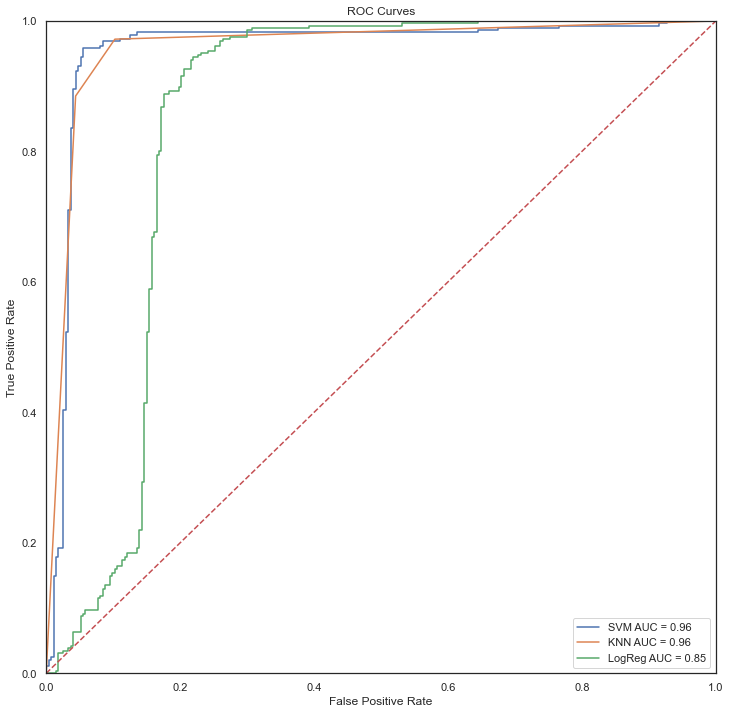

In [137]:
fig, ax=plt.subplots(figsize=(12,12))

y_scores = grid.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(Y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

y_scores2 = grid2.predict_proba(X_test)
fpr2, tpr2, threshold2 = roc_curve(Y_test, y_scores2[:, 1])
roc_auc2 = auc(fpr2, tpr2)

y_scores3 = grid3.predict_proba(X_test)
fpr3, tpr3, threshold3 = roc_curve(Y_test, y_scores3[:, 1])
roc_auc3 = auc(fpr3, tpr3)

plt.title('Receiver Operating Characteristic')

ax.plot(fpr, tpr, label = 'SVM AUC = %0.2f' % roc_auc)
ax.plot(fpr2, tpr2, label = 'KNN AUC = %0.2f' % roc_auc2)
ax.plot(fpr3, tpr3, label = 'LogReg AUC = %0.2f' % roc_auc3)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curves')
plt.show()

In [72]:
# classifiers = [grid, grid2, grid3]
# ax = plt.gca()
# for i in classifiers:
#     plot_roc_curve(i, X_test, Y_test, ax=ax)

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods:

Text(0.5, 1.0, 'Precision-Recall curve')

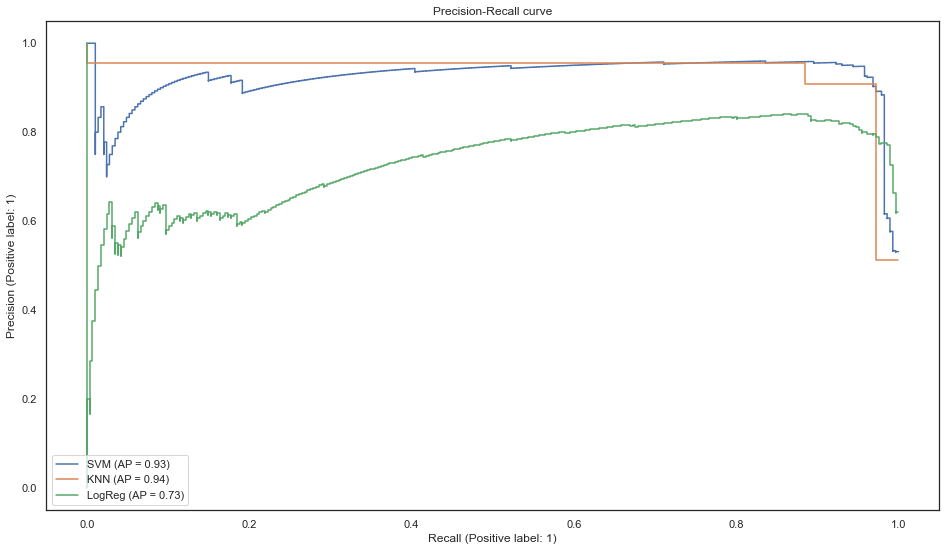

In [138]:
plt.figure(figsize=(16,9))

plot_precision_recall_curve(grid, X_test, Y_test, ax = plt.gca(),name = "SVM")

plot_precision_recall_curve(grid2, X_test, Y_test, ax = plt.gca(),name = "KNN")

plot_precision_recall_curve(grid3, X_test, Y_test, ax = plt.gca(),name = "LogReg")

plt.title('Precision-Recall curve')

In [90]:
threshold=np.linspace(0,1, 500)
metrics0=[]

for i in threshold:

    Y_predicted=(grid.predict_proba(X_train)[:,1]>=i).astype(int)
    metrics0.append((precision_score(Y_predicted ,Y_train), recall_score(Y_predicted, Y_train), fbeta_score(Y_predicted, Y_train, beta=.5)))

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
metrics03=[]

for i in threshold:
    
    Y_predicted=(grid3.predict_proba(X_train)[:,1]>=i).astype(int)
    metrics03.append((precision_score(Y_predicted ,Y_train), recall_score(Y_predicted, Y_train), fbeta_score(Y_predicted, Y_train, beta=.5)))

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_divis

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_divis

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_divis

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_divis

In [92]:
metrics=np.array((metrics0))
metrics3=np.array((metrics03))

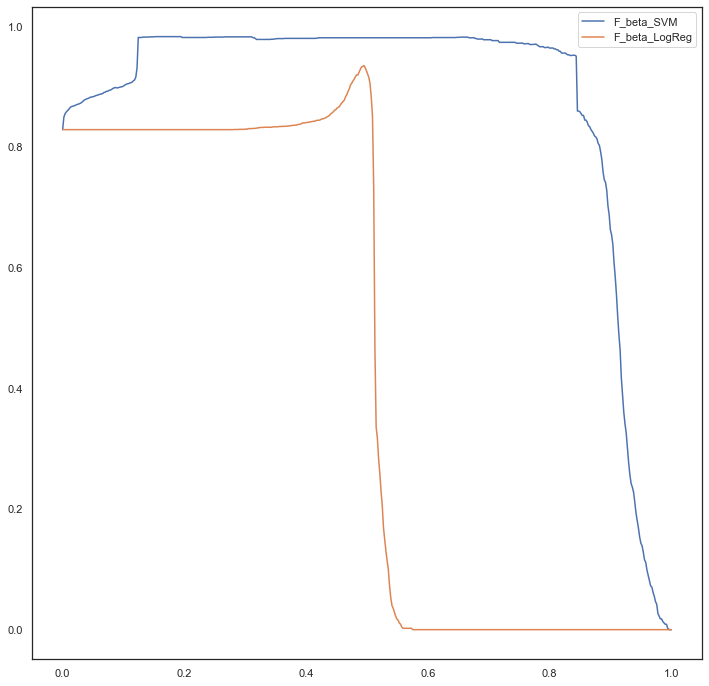

In [93]:
fig, ax=plt.subplots(figsize=(12,12))

# ax.scatter(threshold, metrics[:,0], label='precision')
# ax.scatter(threshold, metrics[:,1], label='recall')
ax.plot(threshold, metrics[:,2], label='F_beta_SVM')
ax.plot(threshold, metrics3[:,2], label='F_beta_LogReg')


plt.legend()